## Face Detection Algorithms Comparison ##

Without Contrast Limited Adaptive Histogram Equalization 

In [2]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import time
import dlib
import mediapipe as mp
import numpy as np
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from facenet_pytorch import MTCNN
from PIL import Image, ImageDraw

2023-09-22 11:52:30.065456: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-22 11:52:30.088521: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-22 11:52:30.243123: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-22 11:52:30.243967: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 11:52:30.982258: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
root_dir = "/home/daniel/testing"
dest_dir_ssd = "/home/daniel/testingSSD"
dest_dir_haar = "/home/daniel/testingHAAR"
dest_dir_dlib = "/home/daniel/testingDLIB"
dest_dir_mp = "/home/daniel/testingMP"
dest_dir_mtcnn = "/home/daniel/testingMTCNN"

## Single Shot Multibox Detector ##

In [3]:
prototxtPath= os.path.join("deploy.prototxt.txt")
caffemodelPath =  os.path.join("res10_300x300_ssd_iter_140000.caffemodel")
detector = cv2.dnn.readNet(prototxtPath, caffemodelPath)

In [4]:
start = time.time()

image_array = cv2.imread('testing/frame_1942.png')

original_size = image_array.shape
target_size = (300, 300)

resized_array = cv2.resize(image_array , target_size)
img = image_array.copy()

aspect_ratio_x = (original_size[1] / target_size[1])
aspect_ratio_y = (original_size[0] / target_size[0])

imageBlob = cv2.dnn.blobFromImage(image= resized_array)

detector.setInput(imageBlob)

detections = detector.forward()

detections_df = pd.DataFrame(detections[0][0], columns = ["img_id", "is_face", "confidence", "left", "top", "right", "bottom"])

detections_df = detections_df[detections_df['is_face'] == 1]
detections_df = detections_df[detections_df['confidence'] >= 0.90]

for i, instance in detections_df.iterrows():

    left = int(instance["left"] * 300)
    bottom = int(instance["bottom"] * 300)
    right = int(instance["right"] * 300)
    top = int(instance["top"] * 300)

    detected_face = img[int(top*aspect_ratio_y):int(bottom*aspect_ratio_y), int(left*aspect_ratio_x):int(right*aspect_ratio_x)].copy()

print("Total time: ", (time.time() - start) * 1000, "milliseconds")

Total time:  44.396162033081055 milliseconds


Face Detected
Confidence:  99.85%
shape (192, 192, 3)


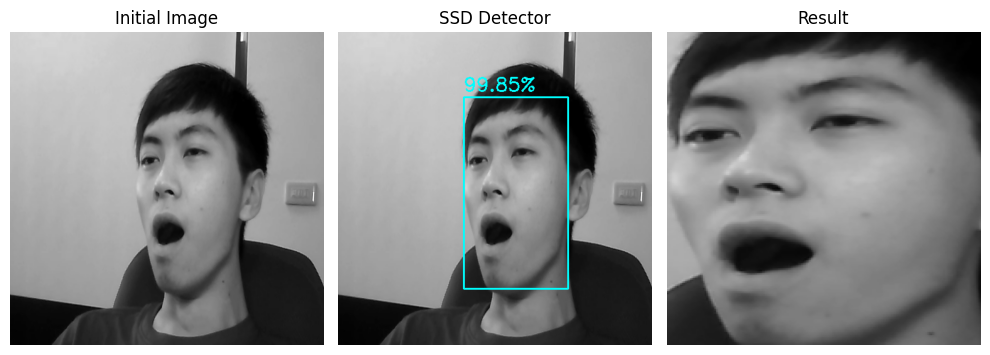

In [5]:
if detected_face.shape[0] > 0 and detected_face.shape[1] > 0:
        confidence_score = str(round(100*instance["confidence"], 2))+"%"
        cv2.putText(img, confidence_score, (int(left*aspect_ratio_x), int(top*aspect_ratio_y-10)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), 2)
        cv2.rectangle(img, (int(left*aspect_ratio_x), int(top*aspect_ratio_y)), (int(right*aspect_ratio_x), int(bottom*aspect_ratio_y)), (0,255,255), 2) 

if i == 0:
    print("Face Detected")
else:
    print("Face Not Detected")
    
print("Confidence: ", confidence_score)
detected_face = cv2.resize(detected_face, (192, 192))
print("shape", detected_face.shape)


fig, axs = plt.subplots(1,3)
axs[0].imshow(image_array)
axs[0].axis('off')
axs[0].set_title("Initial Image")
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title("SSD Detector")
axs[2].imshow(detected_face)
axs[2].axis('off')
axs[2].set_title("Result")

fig.set_figwidth(10)
plt.tight_layout()
plt.show()

In [6]:
start = time.time()

for images in os.listdir(root_dir):
    image_path = os.path.join(root_dir, images)
    image_array = cv2.imread(image_path)

    original_size = image_array.shape
    target_size = (300, 300)

    resized_array = cv2.resize(image_array , target_size)

    aspect_ratio_x = (original_size[1] / target_size[1])
    aspect_ratio_y = (original_size[0] / target_size[0])

    imageBlob = cv2.dnn.blobFromImage(image= resized_array)

    detector.setInput(imageBlob)

    detections = detector.forward()

    detections_df = pd.DataFrame(detections[0][0], columns = ["img_id", "is_face", "confidence", "left", "top", "right", "bottom"])

    detections_df = detections_df[detections_df['is_face'] == 1]
    detections_df = detections_df[detections_df['confidence'] >= 0.90]

    for i, instance in detections_df.iterrows():

        left = int(instance["left"] * 300)
        bottom = int(instance["bottom"] * 300)
        right = int(instance["right"] * 300)
        top = int(instance["top"] * 300)

        detected_face = image_array[int(top*aspect_ratio_y):int(bottom*aspect_ratio_y), int(left*aspect_ratio_x):int(right*aspect_ratio_x)].copy()
        output_path = os.path.join(dest_dir_ssd, images)

        cv2.imwrite(output_path, detected_face)


total_time = (time.time() - start) * 1000
total_per_frame = total_time/3000
fps = 1000/total_per_frame
detection_rate = (len(os.listdir(dest_dir_ssd))/3000) * 100 

print("Total time: ", total_time, "milliseconds")
print("Total time per frame: ", total_per_frame, "milliseconds")
print("Frames per second: ", fps)
print("Total Detection Rate: ", detection_rate, " %")

Total time:  62960.27994155884 milliseconds
Total time per frame:  20.98675998051961 milliseconds
Frames per second:  47.64908927953733
Total Detection Rate:  79.36666666666666  %


## DLIB Frontal Face Detector HOG + SVM ##

In [7]:
face_detector = dlib.get_frontal_face_detector()

In [8]:
start = time.time()

image_array = cv2.imread('testing/frame_1942.png')

img = image_array.copy()

faces = face_detector(img,1)
for (i, rect) in enumerate(faces):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

detected_face = img[y:h+y,x:w+x].copy()

print("Total time: ", (time.time() - start) * 1000, "milliseconds")         

Total time:  139.4193172454834 milliseconds


Confidence:  123.29%
shape (192, 192, 3)


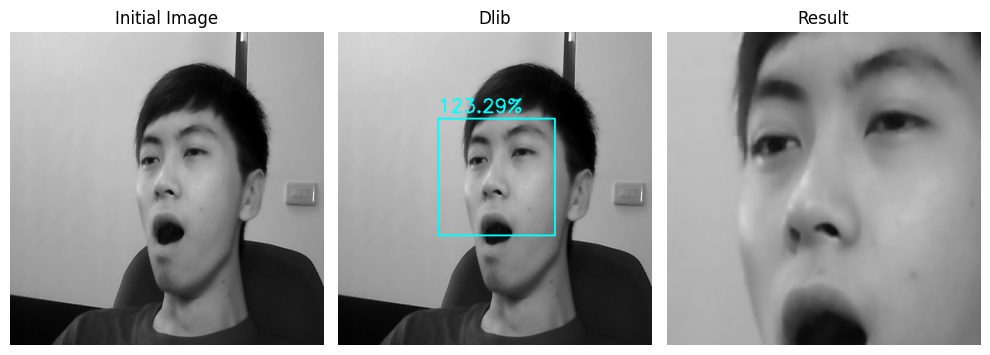

In [9]:
_, scores, _ = face_detector.run(img, 1)
confidence_score = str(round(100*scores[0], 2))+"%"
cv2.putText(img, confidence_score, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), 2)

cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 255), 2)

detected_face = cv2.resize(detected_face, (192, 192))
print("Confidence: ", confidence_score)
print("shape", detected_face.shape)

fig, axs = plt.subplots(1,3)
axs[0].imshow(image_array)
axs[0].axis('off')
axs[0].set_title("Initial Image")
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title("Dlib")
axs[2].imshow(detected_face)
axs[2].axis('off')
axs[2].set_title("Result")

fig.set_figwidth(10)
plt.tight_layout()
plt.show()

In [10]:
start = time.time()

for images in os.listdir(root_dir):
    detected_face = None
    image_path = os.path.join(root_dir, images)
    image_array = cv2.imread(image_path)

    faces = face_detector(image_array,1)
    
    for (i, rect) in enumerate(faces):
        x = rect.left()
        y = rect.top()
        w = rect.right() - x
        h = rect.bottom() - y
        detected_face = image_array[y:h+y,x:w+x].copy()

    output_path = os.path.join(dest_dir_dlib, images)

    if detected_face is not None and detected_face.size>0:
        cv2.imwrite(output_path, detected_face)


total_time = (time.time() - start) * 1000
total_per_frame = total_time/3000
fps = 1000/total_per_frame
detection_rate = (len(os.listdir(dest_dir_dlib))/3000) * 100 

print("Total time: ", total_time, "milliseconds")
print("Total time per frame: ", total_per_frame, "milliseconds")
print("Frames per second: ", fps)
print("Total Detection Rate: ", detection_rate, " %")

Total time:  74279.36148643494 milliseconds
Total time per frame:  24.759787162144978 milliseconds
Frames per second:  40.38806930977546
Total Detection Rate:  64.13333333333333  %


## Haar Cascade Classifier ##

In [11]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [12]:
start = time.time()

image_array = cv2.imread('testing/frame_1942.png')

img = image_array.copy()

faces = face_cascade.detectMultiScale(img)

for (x, y, w, h) in faces:
    
    detected_face = img[y:y+h, x:x+w].copy()

print("Total time: ", (time.time() - start) * 1000, "milliseconds")     

Total time:  25.09617805480957 milliseconds


shape (192, 192, 3)


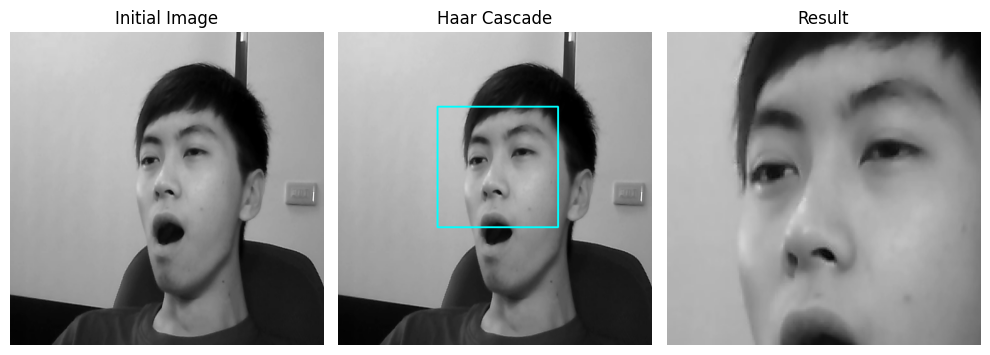

In [13]:
cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 255), 2)
detected_face = cv2.resize(detected_face, (192, 192))
print("shape", detected_face.shape)

fig, axs = plt.subplots(1,3)
axs[0].imshow(image_array)
axs[0].axis('off')
axs[0].set_title("Initial Image")
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title("Haar Cascade")
axs[2].imshow(detected_face)
axs[2].axis('off')
axs[2].set_title("Result")

fig.set_figwidth(10)
plt.tight_layout()
plt.show()

In [14]:
start = time.time()

for images in os.listdir(root_dir):
    detected_face = None
    image_path = os.path.join(root_dir, images)
    image_array = cv2.imread(image_path)

    faces = face_cascade.detectMultiScale(image_array)

    for (x, y, w, h) in faces:
    
        detected_face = image_array[y:y+h, x:x+w].copy()
        
    output_path = os.path.join(dest_dir_haar, images)

    if detected_face is not None and detected_face.size>0:
        cv2.imwrite(output_path, detected_face)


total_time = (time.time() - start) * 1000
total_per_frame = total_time/3000
fps = 1000/total_per_frame
detection_rate = (len(os.listdir(dest_dir_haar))/3000) * 100 

print("Total time: ", total_time, "milliseconds")
print("Total time per frame: ", total_per_frame, "milliseconds")
print("Frames per second: ", fps)
print("Total Detection Rate: ", detection_rate, " %")

Total time:  29360.586643218994 milliseconds
Total time per frame:  9.786862214406332 milliseconds
Frames per second:  102.17779489405632
Total Detection Rate:  64.13333333333333  %


## Mediapipe Face Detector ##

In [15]:
base_options = python.BaseOptions(model_asset_path='detector.tflite')
options = vision.FaceDetectorOptions(base_options=base_options)
detector = vision.FaceDetector.create_from_options(options)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [16]:
start = time.time()

image_array = cv2.imread('testing/frame_1942.png')

img = image_array.copy()
image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_array)

detection_result = detector.detect(image)

for detection in detection_result.detections:

    bbox = detection.bounding_box
    detected_face = img[int(bbox.origin_y):int(bbox.origin_y + bbox.height), int(bbox.origin_x):int(bbox.origin_x + bbox.width)].copy()
    
print("Total time: ", (time.time() - start) * 1000, "milliseconds")

Total time:  9.387969970703125 milliseconds


Confidence:  85.65%
shape (192, 192, 3)


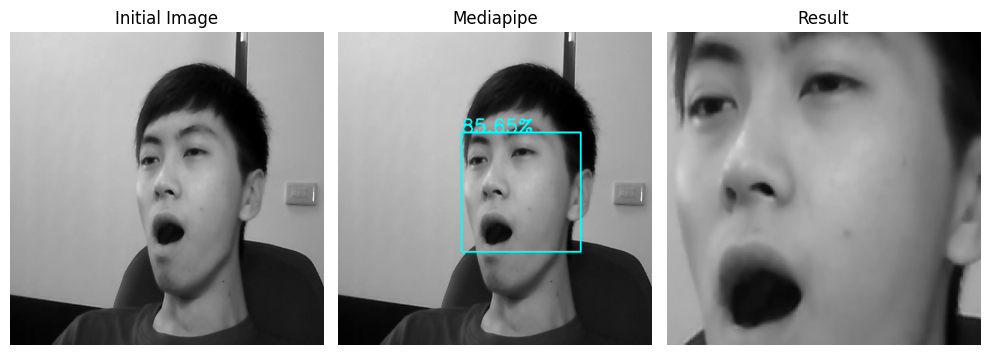

In [17]:
cv2.rectangle(img, (bbox.origin_x, bbox.origin_y), (bbox.origin_x + bbox.width, bbox.origin_y + bbox.height), (0, 255, 255), 2)
category = detection.categories[0]
confidence_score = str(round(100*category.score, 2))+"%"
cv2.putText(img, confidence_score, (bbox.origin_x, bbox.origin_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

detected_face = cv2.resize(detected_face, (192, 192))
print("Confidence: ", confidence_score)
print("shape", detected_face.shape)

fig, axs = plt.subplots(1,3)
axs[0].imshow(image_array)
axs[0].axis('off')
axs[0].set_title("Initial Image")
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title("Mediapipe")
axs[2].imshow(detected_face)
axs[2].axis('off')
axs[2].set_title("Result")

fig.set_figwidth(10)
plt.tight_layout()
plt.show()

In [18]:
start = time.time()

for images in os.listdir(root_dir):
    
    detected_face = None
    image_path = os.path.join(root_dir, images)
    image_array = cv2.imread(image_path)

    image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_array)

    detection_result = detector.detect(image)

    for detection in detection_result.detections:

        bbox = detection.bounding_box
        detected_face = image_array[int(bbox.origin_y):int(bbox.origin_y + bbox.height), int(bbox.origin_x):int(bbox.origin_x + bbox.width)].copy()
    
    output_path = os.path.join(dest_dir_mp, images)

    if detected_face is not None and detected_face.size>0:
        cv2.imwrite(output_path, detected_face)


total_time = (time.time() - start) * 1000
total_per_frame = total_time/3000
fps = 1000/total_per_frame
detection_rate = (len(os.listdir(dest_dir_mp))/3000) * 100 

print("Total time: ", total_time, "milliseconds")
print("Total time per frame: ", total_per_frame, "milliseconds")
print("Frames per second: ", fps)
print("Total Detection Rate: ", detection_rate, " %")

Total time:  9614.229917526245 milliseconds
Total time per frame:  3.2047433058420816 milliseconds
Frames per second:  312.0374721360839
Total Detection Rate:  98.23333333333333  %


## MTCNN Detector ##

In [19]:
mtcnn = MTCNN(select_largest=False)

In [20]:
start = time.time()

image_array = cv2.imread('testing/frame_1942.png')

img = Image.fromarray(image_array)

boxes, probs = mtcnn.detect(img)
draw = ImageDraw.Draw(img)

for box in boxes:
    rectangle = box.tolist()
    detected_face = img.crop(rectangle)

print("Total time: ", (time.time() - start) * 1000, "milliseconds")

Total time:  57.59382247924805 milliseconds


Confidence:  99.8%
(192, 192)


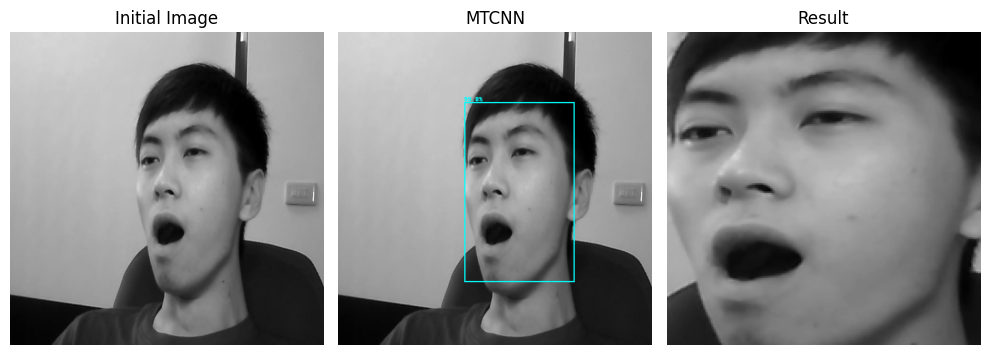

In [21]:
confidence_score = str(round(100*probs[0], 2))+"%"
draw.text((rectangle[0], rectangle[1]-10), confidence_score, (0, 255, 255))
draw.rectangle(rectangle, outline=(0, 255, 255), width=2)
detected_face = detected_face.resize((192, 192))
print("Confidence: ", confidence_score)
print(detected_face.size)

fig, axs = plt.subplots(1,3)
axs[0].imshow(image_array)
axs[0].axis('off')
axs[0].set_title("Initial Image")
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title("MTCNN")
axs[2].imshow(detected_face)
axs[2].axis('off')
axs[2].set_title("Result")

fig.set_figwidth(10)
plt.tight_layout()
plt.show()

In [22]:
start = time.time()

for images in os.listdir(root_dir):
    detected_face = None
    image_path = os.path.join(root_dir, images)
    image_array = cv2.imread(image_path)

    img = Image.fromarray(image_array)

    boxes, probs = mtcnn.detect(img)

    if boxes is None:
        continue
    
    for box in boxes:
        rectangle = box.tolist()
        detected_face = img.crop(rectangle)
    
    output_path = os.path.join(dest_dir_mtcnn, images)
    
    if detected_face is not None:
        detected_face.save(output_path)


total_time = (time.time() - start) * 1000
total_per_frame = total_time/3000
fps = 1000/total_per_frame
detection_rate = (len(os.listdir(dest_dir_mtcnn))/3000) * 100 

print("Total time: ", total_time, "milliseconds")
print("Total time per frame: ", total_per_frame, "milliseconds")
print("Frames per second: ", fps)
print("Total Detection Rate: ", detection_rate, " %")

Total time:  54915.447473526 milliseconds
Total time per frame:  18.305149157842 milliseconds
Frames per second:  54.62943739912635
Total Detection Rate:  79.06666666666666  %


## The effect of Constrast Limited Adaptive Histogram Equalization ##

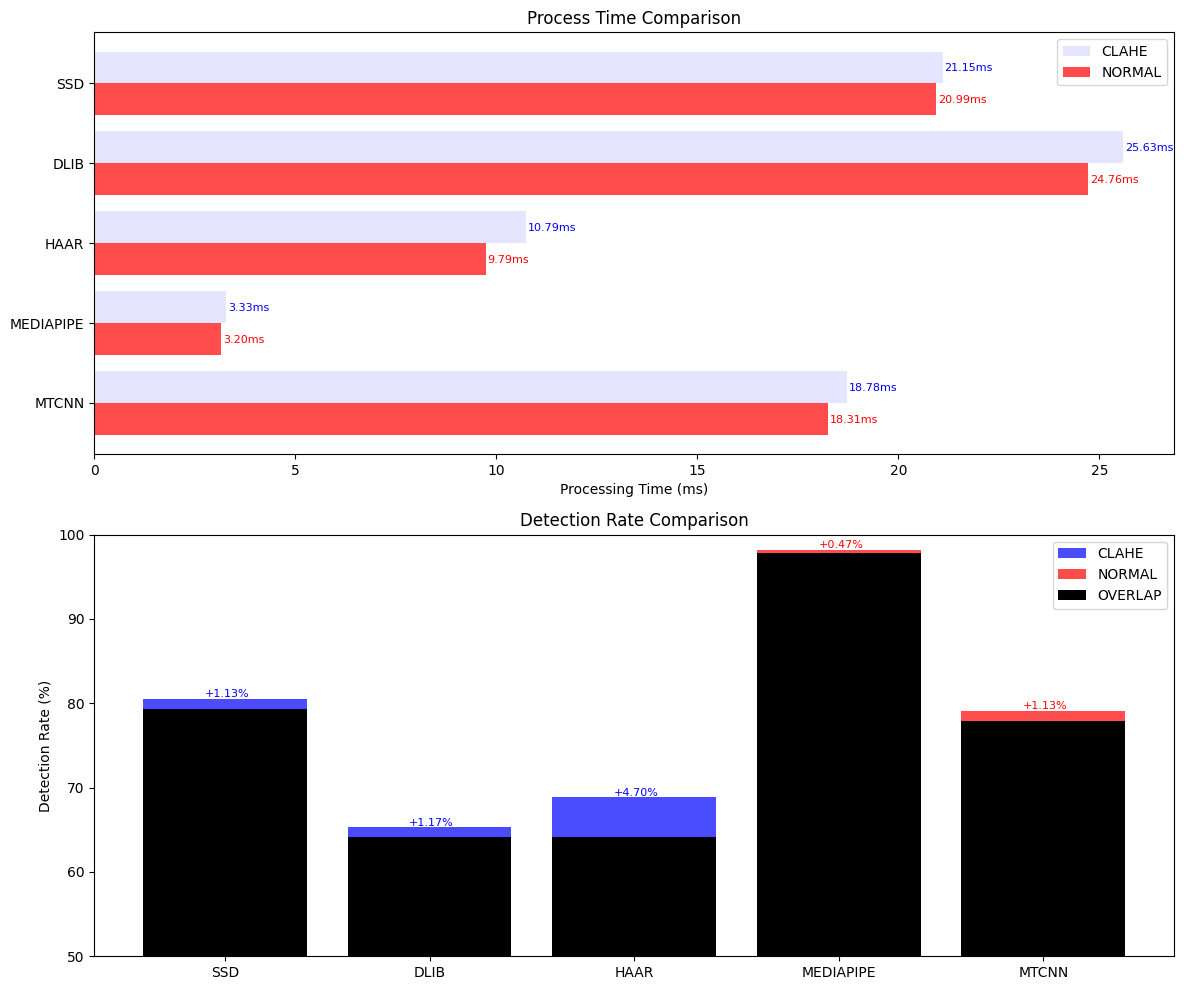

In [41]:
detectors = ['SSD', 'DLIB', 'HAAR', 'MEDIAPIPE', 'MTCNN']
process_types = ['CLAHE', 'NORMAL']

process_time_clahe = [21.149883429209392, 25.63260579109192, 10.79240624109904, 3.3275347550710044, 18.78115979830424]
process_time_normal = [20.98675998051961, 24.759787162144978, 9.786862214406332, 3.2047433058420816, 18.305149157842]

detection_rate_clahe = [80.5, 65.3, 68.83333333333333, 97.76666666666667, 77.93333333333334]
detection_rate_normal = [79.36666666666666, 64.13333333333333, 64.13333333333333, 98.23333333333333, 79.06666666666666]

fig, axs = plt.subplots(2, 1, figsize=(12, 10))

axs[0].set_xlabel('Processing Time (ms)')
axs[0].set_title('Process Time Comparison')


for i, time in enumerate(process_time_clahe):
    if time > process_time_normal[i]:
        alpha_clahe = 0.1
        alpha_normal = 0.7
    else:
        alpha_clahe = 0.7
        alpha_normal = 0.1
    
    if i == 0:
        axs[0].barh(i - 0.2, process_time_clahe[i] - 0.05, height=0.4, label="CLAHE", color='blue', alpha=alpha_clahe)
        axs[0].barh(i + 0.2, process_time_normal[i] - 0.05, height=0.4, label="NORMAL", color='red', alpha=alpha_normal)
    else:
        axs[0].barh(i - 0.2, process_time_clahe[i] - 0.05, height=0.4, color='blue', alpha=alpha_clahe)
        axs[0].barh(i + 0.2, process_time_normal[i] - 0.05, height=0.4, color='red', alpha=alpha_normal)

    axs[0].text(process_time_clahe[i], i - 0.15, f'{process_time_clahe[i]:.2f}ms', fontsize=8, color='blue')
    axs[0].text(process_time_normal[i], i + 0.25, f'{process_time_normal[i]:.2f}ms', fontsize=8, color='red')


axs[0].set_yticks(np.arange(len(detectors)))
axs[0].set_yticklabels(detectors)
axs[0].invert_yaxis()
axs[0].legend()

min_detection_rate = [min(detection_rate_clahe[i], detection_rate_normal[i]) for i,_ in enumerate(detectors)]
differences = [clahe_rate - normal_rate if clahe_rate > normal_rate else normal_rate - clahe_rate for clahe_rate, normal_rate in zip(detection_rate_clahe, detection_rate_normal)]

axs[1].set_ylabel('Detection Rate (%)')
axs[1].set_title('Detection Rate Comparison')
axs[1].set_ylim(50, 100)
axs[1].bar(detectors, detection_rate_clahe, label='CLAHE', color='blue', alpha=0.7)
axs[1].bar(detectors, detection_rate_normal, label='NORMAL', color='red', alpha=0.7)
axs[1].bar(detectors, min_detection_rate, label='OVERLAP', color='black', alpha=1.0)

for i, rate in enumerate(detection_rate_clahe):
    if rate > detection_rate_normal[i]:
        axs[1].text(i-0.10, detection_rate_clahe[i] + 0.2, f'+{differences[i]:.2f}%', fontsize=8, color='blue')
    else:
        axs[1].text(i-0.10, detection_rate_normal[i] + 0.2, f'+{differences[i]:.2f}%', fontsize=8, color='red')

axs[1].set_xticks(np.arange(len(detectors)))
axs[1].set_xticklabels(detectors)
axs[1].legend()


plt.tight_layout()
plt.show()
